In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
from google.colab import drive
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Set up Darknet for YOLOv4

In [ ]:
# Mount google drive
%cd ..
drive.mount('/content/gdrive')

# Symbolic link: the path '/content/gdrive/My\ Drive/' is equal to '/mydrive'
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
%cd /mydrive/yolov4
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# Enable GPU, OPENCV and LIBSO
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/gdrive/My Drive/yolov4/darknet


In [ ]:
# Build darknet: this allows to use the darknet.py file and its dependencies
!make

In [ ]:
# Load the YOLO (v4) model for 80 multi-class object detection 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

## Transfer learning: custom dataset

In [ ]:
# Clean the 'data' and 'cfg' darknet folders, but keep the 'labels' folder in 'data'
%cd data/
!find -maxdepth 1 -type f -exec rm -rf {} \;
%cd ..
%rm -rf cfg/
%mkdir cfg

In [ ]:
# Unzip the 'obj' dataset folder and copy it in 'data'
!unzip /mydrive/yolov4/obj.zip -d data/

In [ ]:
# Copy the files 'yolov4-custom.cfg', 'obj.names' and 'obj.data' in the 'cfg' and 'data' darknet folders
!cp /mydrive/yolov4/yolov4-custom.cfg cfg
!cp /mydrive/yolov4/obj.names data
!cp /mydrive/yolov4/obj.data data

In [ ]:
# Copy the process.py file to the current darknet directory and run it
!cp /mydrive/yolov4/process.py .
!python process.py  # this creates the train.txt and test.txt files in the 'data' darknet folder

In [ ]:
# Load pre-trained weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

#### Custom detector training


In [ ]:
# Training on the custom dataset
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# Restart training from the last saved weights (if needed)
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_last.weights -dont_show -map

## Test on pictures

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  fig = plt.gcf()
  fig.set_size_inches(8, 6)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
# Test the model on an image ('/mydrive/yolov4/image.jpg')
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_last.weights /mydrive/yolov4/image.jpg -thresh 0.3 

#### Image utils

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# Test mode configuration
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

#### Webcam picture test

In [ ]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_last.weights photo.jpg -thresh 0.3 

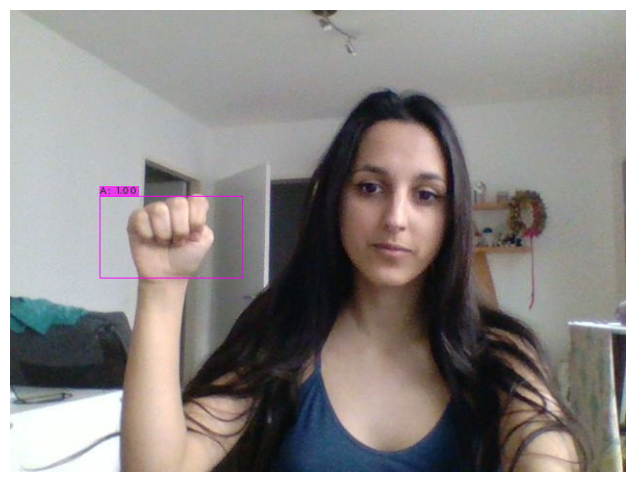

In [ ]:
imShow('sampleA.jpg')   

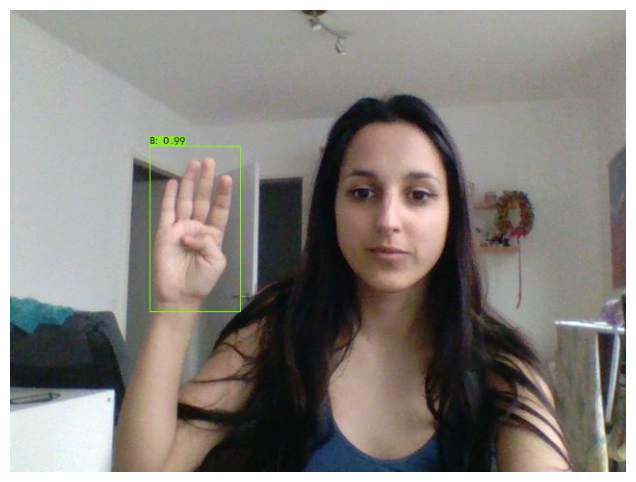

In [ ]:
imShow('sampleB.jpg')   

## Test on video

In [ ]:
# Test the model on a recorded video ('/mydrive/yolov4/video.mp4')
!./darknet detector demo data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_last.weights -dont_show /mydrive/yolov4/video.mp4 -i 0 -out_filename /mydrive/yolov4/video_pred.avi 

#### Video Utils

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: black; font-weight: bold;">' +
          'When finished, click the bottom below to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      const stop_demo = document.createElement('button');
      stop_demo.textContent = 'STOP DEMO';
      div.appendChild(stop_demo);
      stop_demo.onclick = () => { shutdown = true; };

      video.srcObject = stream;

      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
from darknet import *
# load the YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/obj.data", "/mydrive/yolov4/training/yolov4-custom_last.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [ ]:
# function to convert the JavaScript object into an OpenCV image

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

#### Real-time webcam test

In [ ]:
# start streaming video from webcam
video_stream()
label_html = 'Capturing...'

# initialzation
bbox = ''
history = [np.nan, np.nan]

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    # color the frame border in white 
    bbox_array = cv2.rectangle(bbox_array, (0, 0), (640, 640), (255, 255, 255), 2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # for the current frame, select the first detection and draw the bounding box on the transparent overlay image
    if detections != []:
      label = detections[0][0]
      bbox = detections[0][2]
      history.append(label)
      # if 'A' and 'B' gestures have been detected one after the other, then plot the signal for help bounding box 
      if history[-2:] == ['A', 'B'] or history[-2:] == ['B', 'A']:
            left, top, right, bottom = bbox2points(bbox)
            left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
            bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 0, 255), 2)
            bbox_array = cv2.putText(bbox_array, "HELP", (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
            bbox_bytes = bbox_to_bytes(bbox_array)
            bbox = bbox_bytes   
    else:
      # othervise, record that no detection has been made
      history.append('none')